In [9]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy.linalg as la

data = fits.open("/mnt/disk2/samarth/HMI_037_8848.fits")[1].data

data1 = data[:, 0::2]
data2 = data[:, 1::2]
data = data1 + 1j*data2

data = np.fft.fft(data)
freq = np.fft.fftfreq(data.shape[1])

freqpos = freq[freq>=0]
data = data[:, freq>=0]
data = abs(data)**2

In [18]:
daylist = [6328+72*i for i in range(5)]
datap_list = []
datan_list = []
mean_datap_list = []
mean_datan_list = []
for day in daylist:
    _datap = np.load(f'../data-files/hmi-200p-{day}.npy')
    _datan = np.load(f'../data-files/hmi-200n-{day}.npy')
    datap_list.append(_datap)
    datan_list.append(_datan)
    mean_datap_list.append(np.mean(_datap, axis=0))
    mean_datan_list.append(np.mean(_datan, axis=0))

Condition number = 55162.295418002046
Condition number = 43543.19788855014


/tmp/ipykernel_23526/947748249.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/tmp/ipykernel_23526/947748249.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


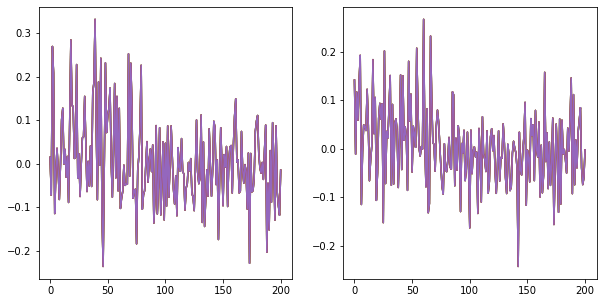

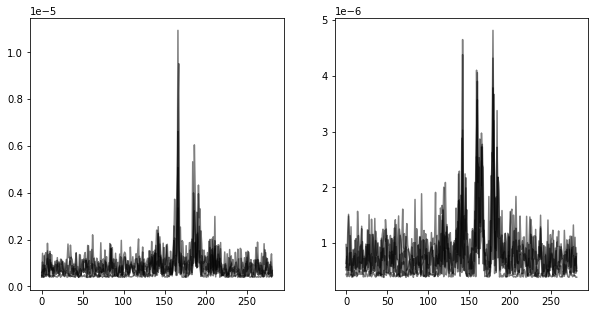

In [25]:
def compute_weights(obsdata, threshold=1.2):
    mean_obsdata = np.mean(obsdata, axis=0)
    med_data = np.median(mean_obsdata)
    
    mask_signal = mean_obsdata < med_data*threshold
    DTD = np.einsum("ij,kj -> ik", 
                    obsdata[:, mask_signal], 
                    obsdata[:, mask_signal])
    inv_DTD = la.inv(DTD)
    weights = np.sum(inv_DTD, axis=0)/np.sum(inv_DTD)
    print(f"Condition number = {la.cond(DTD)}")
    return weights

def get_mean_data(obsdata):
    len_data = len(obsdata)
    mean_data = sum(obsdata)/len_data
    return mean_data

def get_std_data(obsdata):
    mean_data = get_mean_data(obsdata)
    diff_data = obsdata - mean_data
    diff2_data = diff_data**2
    mean_diff2 = sum(diff2_data)/len(diff2_data)
    return np.sqrt(mean_diff2)

def plot_weighted_data(dtp, dtn, wdtp, wdtn, axs, day=6328):
    dc_shiftp = np.mean(dtp, axis=0)[:50].mean()
    dc_shiftn = np.mean(dtn, axis=0)[:50].mean()
    axs[0].plot(dc_shiftp+abs(wdtp), 'k', alpha=0.5, label=f'using optimal weights: {day}')
    axs[1].plot(dc_shiftn+abs(wdtn), 'k', alpha=0.5, label=f'using optimal weights: {day}')
    return axs

weightsp_list = []
weightsn_list = []

weighted_datap_list = []
weighted_datan_list = []

fig1, axs1 = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs1 = axs1.flatten()
_wp = compute_weights(datap_list[0])
_wn = compute_weights(datan_list[0])
for idx, day in enumerate(daylist):
    axs1[0].plot(_wp, label=f'weights: {day}')
    axs1[1].plot(_wn, label=f'weights: {day}')
    weightsp_list.append(_wp)
    weightsn_list.append(_wn)
    weighted_datap_list.append(_wp @ datap_list[idx])
    weighted_datan_list.append(_wn @ datan_list[idx])
fig1.show()
    
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs = axs.flatten()
for idx, day in enumerate(daylist):
    axs = plot_weighted_data(datap_list[idx],
                             datan_list[idx],
                             weighted_datap_list[idx],
                             weighted_datan_list[idx],
                             axs,
                             day=day)
fig.show()

exp_datap = get_mean_data(mean_datap_list)
exp_datan = get_mean_data(mean_datan_list)
std_datap = get_std_data(mean_datap_list)
std_datan = get_std_data(mean_datan_list)

wgt_datap = get_mean_data(weighted_datap_list)
wgt_datan = get_mean_data(weighted_datan_list)
std_wgtp = get_std_data(weighted_datap_list)
std_wgtn = get_std_data(weighted_datan_list)

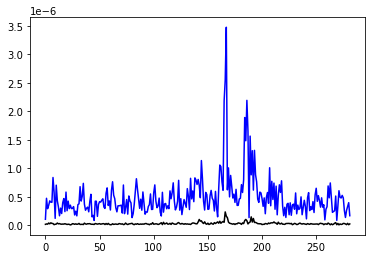

In [26]:
plt.figure()
plt.plot(std_datap, 'k')
plt.plot(std_wgtp, 'b')
plt.show()

In [61]:
weighted_datap = weightsp @ datap
weighted_datan = weightsn @ datan

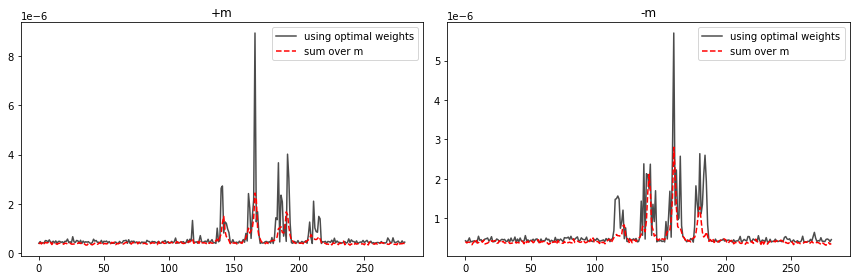

In [69]:
dc_shiftp = np.mean(datap, axis=0)[:50].mean()
dc_shiftn = np.mean(datan, axis=0)[:50].mean()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs = axs.flatten()
axs[0].plot(dc_shiftp+abs(weighted_datap), 'k', alpha=0.7, label='using optimal weights')
axs[0].plot(np.mean(datap, axis=0), '--r', label='sum over m')
axs[0].legend()
axs[0].set_title('+m')

axs[1].plot(dc_shiftn+abs(weighted_datan), 'k', alpha=0.7, label='using optimal weights')
axs[1].plot(np.mean(datan, axis=0), '--r', label='sum over m')
axs[1].legend()
axs[1].set_title('-m')
plt.tight_layout()
plt.show()


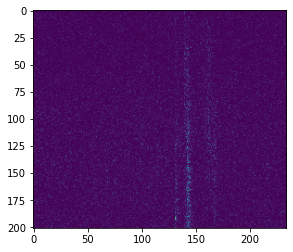

In [70]:
plt.figure()
plt.imshow(data[:, mask_signal])
plt.show()

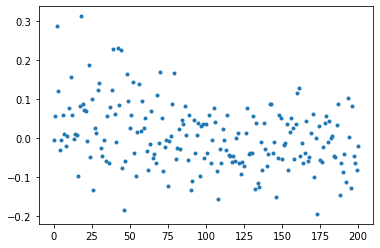

In [43]:
plt.figure()
plt.plot(weights, '.')
plt.show()

In [14]:
data.mean()

4.779714415149917e-07